In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import os

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Load datasets

In [3]:
dataset_path = '../../dataset/additional_datasets/'
dataset_name = 'Breast_GSE45827'
dataset_norm_suffix = '_norm'
dataset_pca_suffix = '_pca'
models_path = 'saved_models/KNN/'

with open('../../preprocessing/class_mapping.pickle', 'rb') as handle:
    class_mapping = pickle.load(handle)

In [4]:
df_norm = pd.read_csv(dataset_path + dataset_name + dataset_norm_suffix + '.csv', index_col=0)
X_norm = df_norm.drop('type', axis=1)
y_norm = df_norm.type

### Create SMOTE and PCA datasets

In [5]:
PCA_COMPONENTS = 90

def pca_dataset(X_train, X_test):
    pca = PCA(n_components=PCA_COMPONENTS)
    pca.fit(X_train)

    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    return X_train_pca, X_test_pca

In [6]:
def smote_dataset(X_train, y_train):
    smt = SMOTE()
    X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train)

    return X_train_smote, y_train_smote

## Train

In [7]:
def train(X, y, params={'n_neighbors': 1, 'p': 1, 'weights': 'distance'}, oversampling=False, pca=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if oversampling:
        X_train, y_train = smote_dataset(X_train, y_train)
    if pca:
        X_train, X_test = pca_dataset(X_train, X_test)

    # create model instance
    model = KNeighborsClassifier(n_neighbors=params['n_neighbors'], p=params['p'], weights=params['weights'])
    # fit model
    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    print('F1 score: ', f1_score(y_test, preds, average='weighted'))

    return model, preds, y_test

### Experiment with neighbor count

In [8]:
def experiment(n_neighbors=4):
    params = {'n_neighbors': n_neighbors, 'p': 2, 'weights': 'distance'}
    _, norm_pred, norm_real = train(X_norm, y_norm, n_neighbors=n_neighbors, oversampling=False, pca=False)
    _, pca_pred, pca_real = train(X_norm, y_norm, n_neighbors=n_neighbors, oversampling=False, pca=True)
    _, norm_res_pred, norm_res_real = train(X_norm, y_norm, n_neighbors=n_neighbors, oversampling=True, pca=False)
    _, pca_res_pred, pca_res_real = train(X_norm, y_norm, n_neighbors=n_neighbors, oversampling=True, pca=True)

    print('Number of neighbors: ', n_neighbors)

    # Original dataset
    print('F1 score of normalized dataset: ', f1_score(norm_real, norm_pred, average='weighted'))
    print('F1 score of PCA dataset: ', f1_score(pca_real, pca_pred, average='weighted'))

    # Oversampled dataset
    print('F1 score of normalized oversampled dataset: ', f1_score(norm_res_real, norm_res_pred, average='weighted'))
    print('F1 score of PCA oversampled dataset: ', f1_score(pca_res_real, pca_res_pred, average='weighted'))

    print('\n')

def start_experiment(min_neighbors=1, max_neighbors=10):
    for n_neighbors in range(min_neighbors, max_neighbors+1):
        experiment(n_neighbors)

# start_experiment(min_neighbors=1, max_neighbors=12)

#### Experiment with GridSearch

In [9]:
def start_gridsearch(X, y, oversampling=False, pca=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if oversampling:
        X_train, y_train = smote_dataset(X_train, y_train)
    if pca:
        X_train, X_test = pca_dataset(X_train, X_test)

    params = {'weights' : ['uniform'], 'p' : range(1,10), 'n_neighbors' : range(1,10)}
    estimator = GridSearchCV(KNeighborsClassifier(), param_grid=params, verbose=4, cv=5)
    estimator.fit(X_train, y_train)

    print(estimator.best_params_)


In [10]:
# estimator_norm = start_gridsearch(X_norm, y_norm, oversampling=False, pca=False)

In [11]:
# estimator_pca = start_gridsearch(X_norm, y_norm, oversampling=False, pca=True)

In [12]:
# estimator_norm_res = start_gridsearch(X_norm, y_norm, oversampling=True, pca=False)

In [13]:
# estimator_pca_res = start_gridsearch(X_norm, y_norm, oversampling=True, pca=True)

In [14]:
norm_model, norm_pred, norm_true = train(X_norm, y_norm, params={'n_neighbors': 3, 'p': 1, 'weights': 'distance'}, oversampling=False, pca=False)
pca_model, pca_pred, pca_true = train(X_norm, y_norm, params={'n_neighbors': 1, 'p': 8, 'weights': 'uniform'}, oversampling=False, pca=True)

F1 score:  0.7442396313364055
F1 score:  0.7700874394422781


In [15]:
norm_res_model, norm_res_pred, norm_res_true = train(X_norm, y_norm, params={'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}, oversampling=True, pca=False)
pca_res_model, pca_res_pred, pca_res_true = train(X_norm, y_norm, params={'n_neighbors': 1, 'p': 4, 'weights': 'uniform'}, oversampling=True, pca=True)

F1 score:  0.8440252031333625
F1 score:  0.8035499305448371


## Results

In [16]:
f1_results = {
    'norm': f1_score(norm_true, norm_pred, average='weighted') * 100,
    'pca': f1_score(pca_true, pca_pred, average='weighted') * 100,
    'norm_res': f1_score(norm_res_true, norm_res_pred, average='weighted') * 100,
    'pca_res': f1_score(pca_res_true, pca_res_pred, average='weighted') * 100
}
acc_results = {
    'norm': accuracy_score(norm_true, norm_pred) * 100,
    'pca': accuracy_score(pca_true, pca_pred) * 100,
    'norm_res': accuracy_score(norm_res_true, norm_res_pred) * 100,
    'pca_res': accuracy_score(pca_res_true, pca_res_pred) * 100
}

In [17]:
# Original dataset
norm_acc = accuracy_score(norm_true, norm_pred)
norm_f1 = f1_score(norm_true, norm_pred, average='weighted')
pca_acc = accuracy_score(pca_true, pca_pred)
pca_f1 = f1_score(pca_true, pca_pred, average='weighted')

print('Accuracy of normalized dataset: ', f'{norm_acc * 100:.2f} %')
print('Accuracy of PCA dataset: ', f'{pca_acc * 100:.2f} %')
print()
print('F1 Score of normalized dataset: ', f'{norm_f1 * 100:.2f} %')
print('F1 Score of PCA dataset: ', f'{pca_f1 * 100:.2f} %')


Accuracy of normalized dataset:  74.19 %
Accuracy of PCA dataset:  77.42 %

F1 Score of normalized dataset:  74.42 %
F1 Score of PCA dataset:  77.01 %


In [18]:
# Oversampled dataset
norm_res_acc = accuracy_score(norm_res_true, norm_res_pred)
norm_res_f1 = f1_score(norm_res_true, norm_res_pred, average='weighted')
pca_res_acc = accuracy_score(pca_res_true, pca_res_pred)
pca_res_f1 = f1_score(pca_res_true, pca_res_pred, average='weighted')

print('Accuracy of normalized oversampled dataset: ', f'{norm_res_acc * 100:.2f} %')
print('Accuracy of PCA oversampled dataset: ', f'{pca_res_acc * 100:.2f} %')
print()
print('F1 Score of normalized oversampled dataset: ', f'{norm_res_f1 * 100:.2f} %')
print('F1 Score of PCA oversampled dataset: ', f'{pca_res_f1 * 100:.2f} %')

Accuracy of normalized oversampled dataset:  83.87 %
Accuracy of PCA oversampled dataset:  80.65 %

F1 Score of normalized oversampled dataset:  84.40 %
F1 Score of PCA oversampled dataset:  80.35 %


## Plot

0    10
5     7
2     5
1     5
4     3
3     1
Name: type, dtype: int64


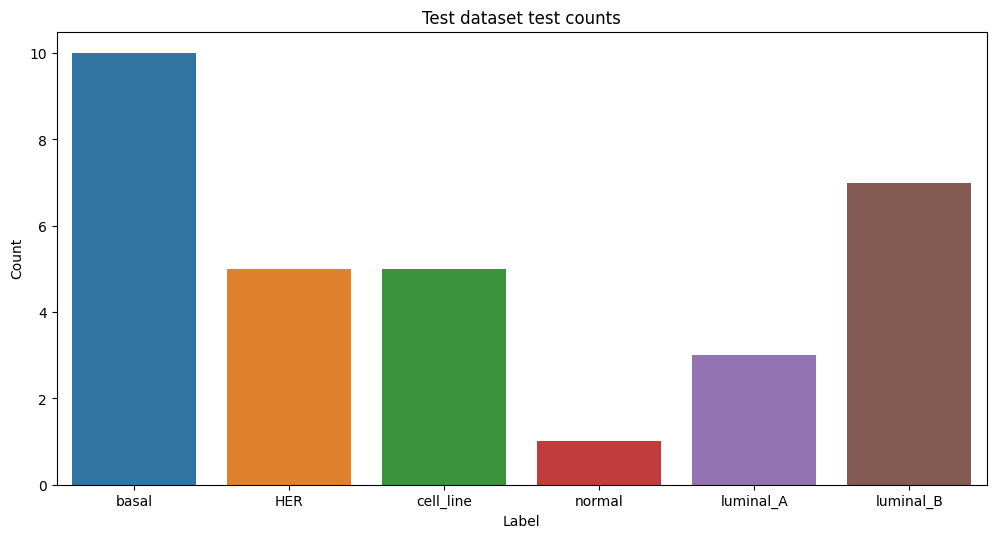

In [19]:
# Check how much values does each label have in test set
test_counts = norm_true.value_counts()
print(test_counts)

# plot test counts
plt.figure(figsize=(12, 6), dpi=100)
sns.barplot(x=test_counts.index, y=test_counts.values)
plt.xticks(range(len(class_mapping)), class_mapping.keys())
plt.title('Test dataset test counts')
plt.ylabel('Count')
plt.xlabel('Label')
plt.show()

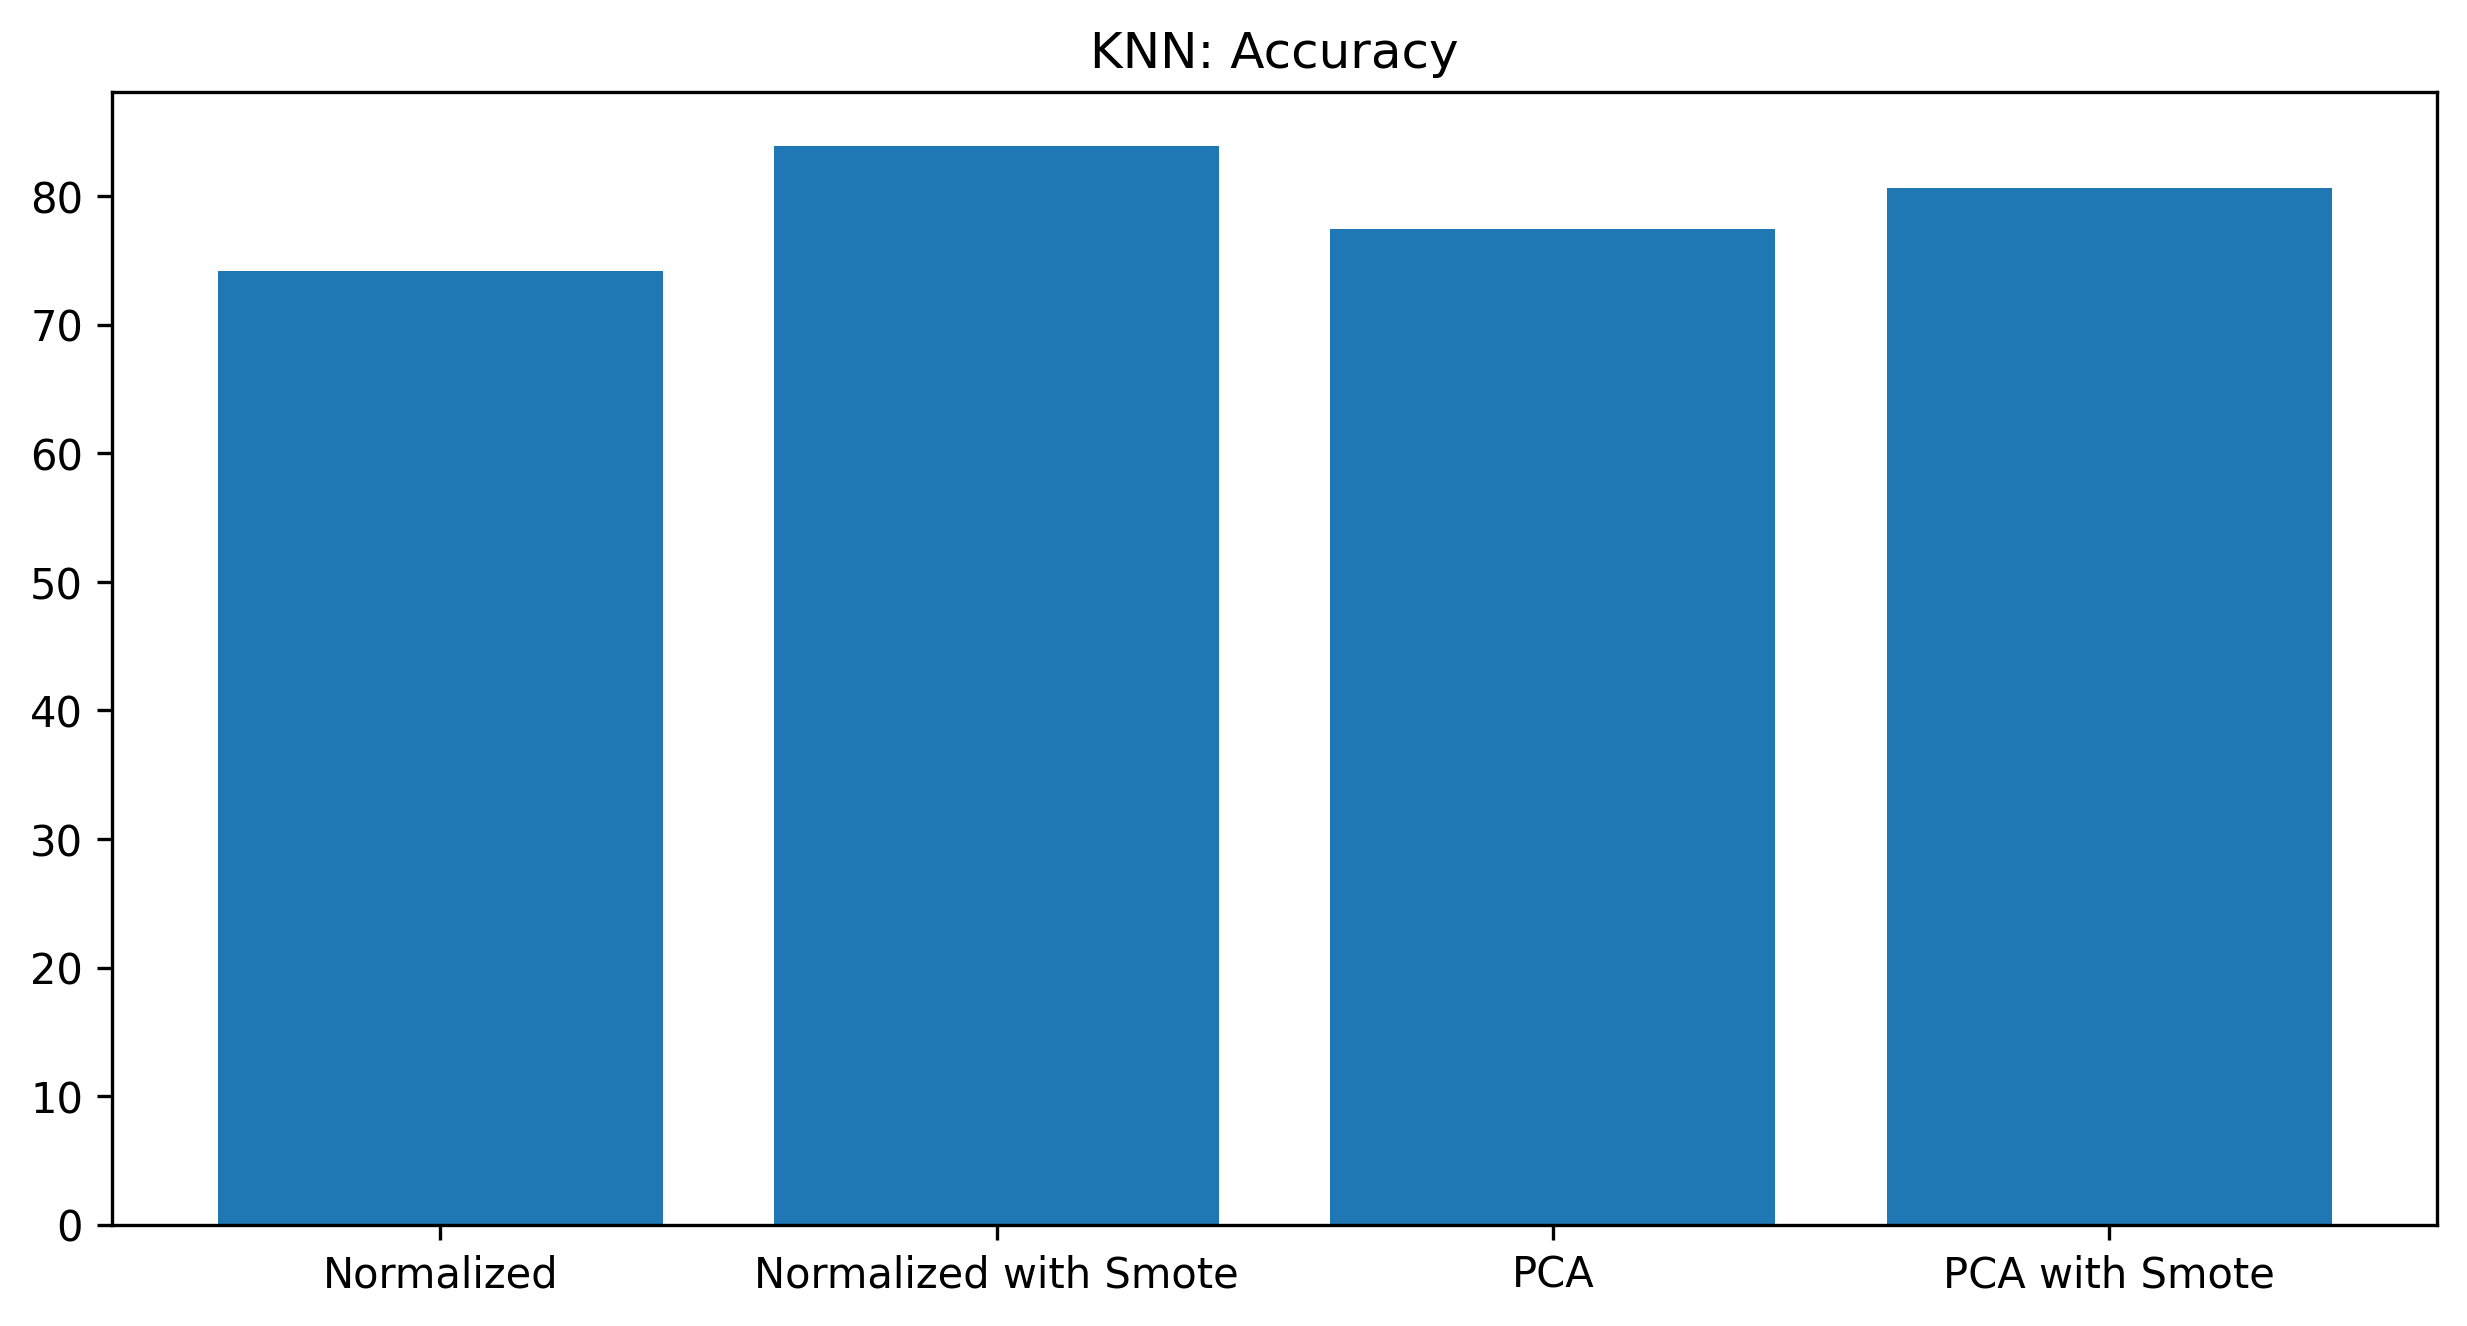

In [20]:
# Plot accuracy

plt.figure(figsize=(10, 5), dpi=300)
plt.bar(
    ['Normalized', 'Normalized with Smote', 'PCA', 'PCA with Smote'], 
    [
        norm_acc * 100,
        norm_res_acc * 100,
        pca_acc * 100,
        pca_res_acc * 100
    ]
)
plt.title('KNN: Accuracy')

# Save figure
if not os.path.exists('../../figures/KNN'):
    os.makedirs('../../figures/KNN')

plt.savefig('../../figures/KNN/KNN Accuracy score.png')

plt.show()

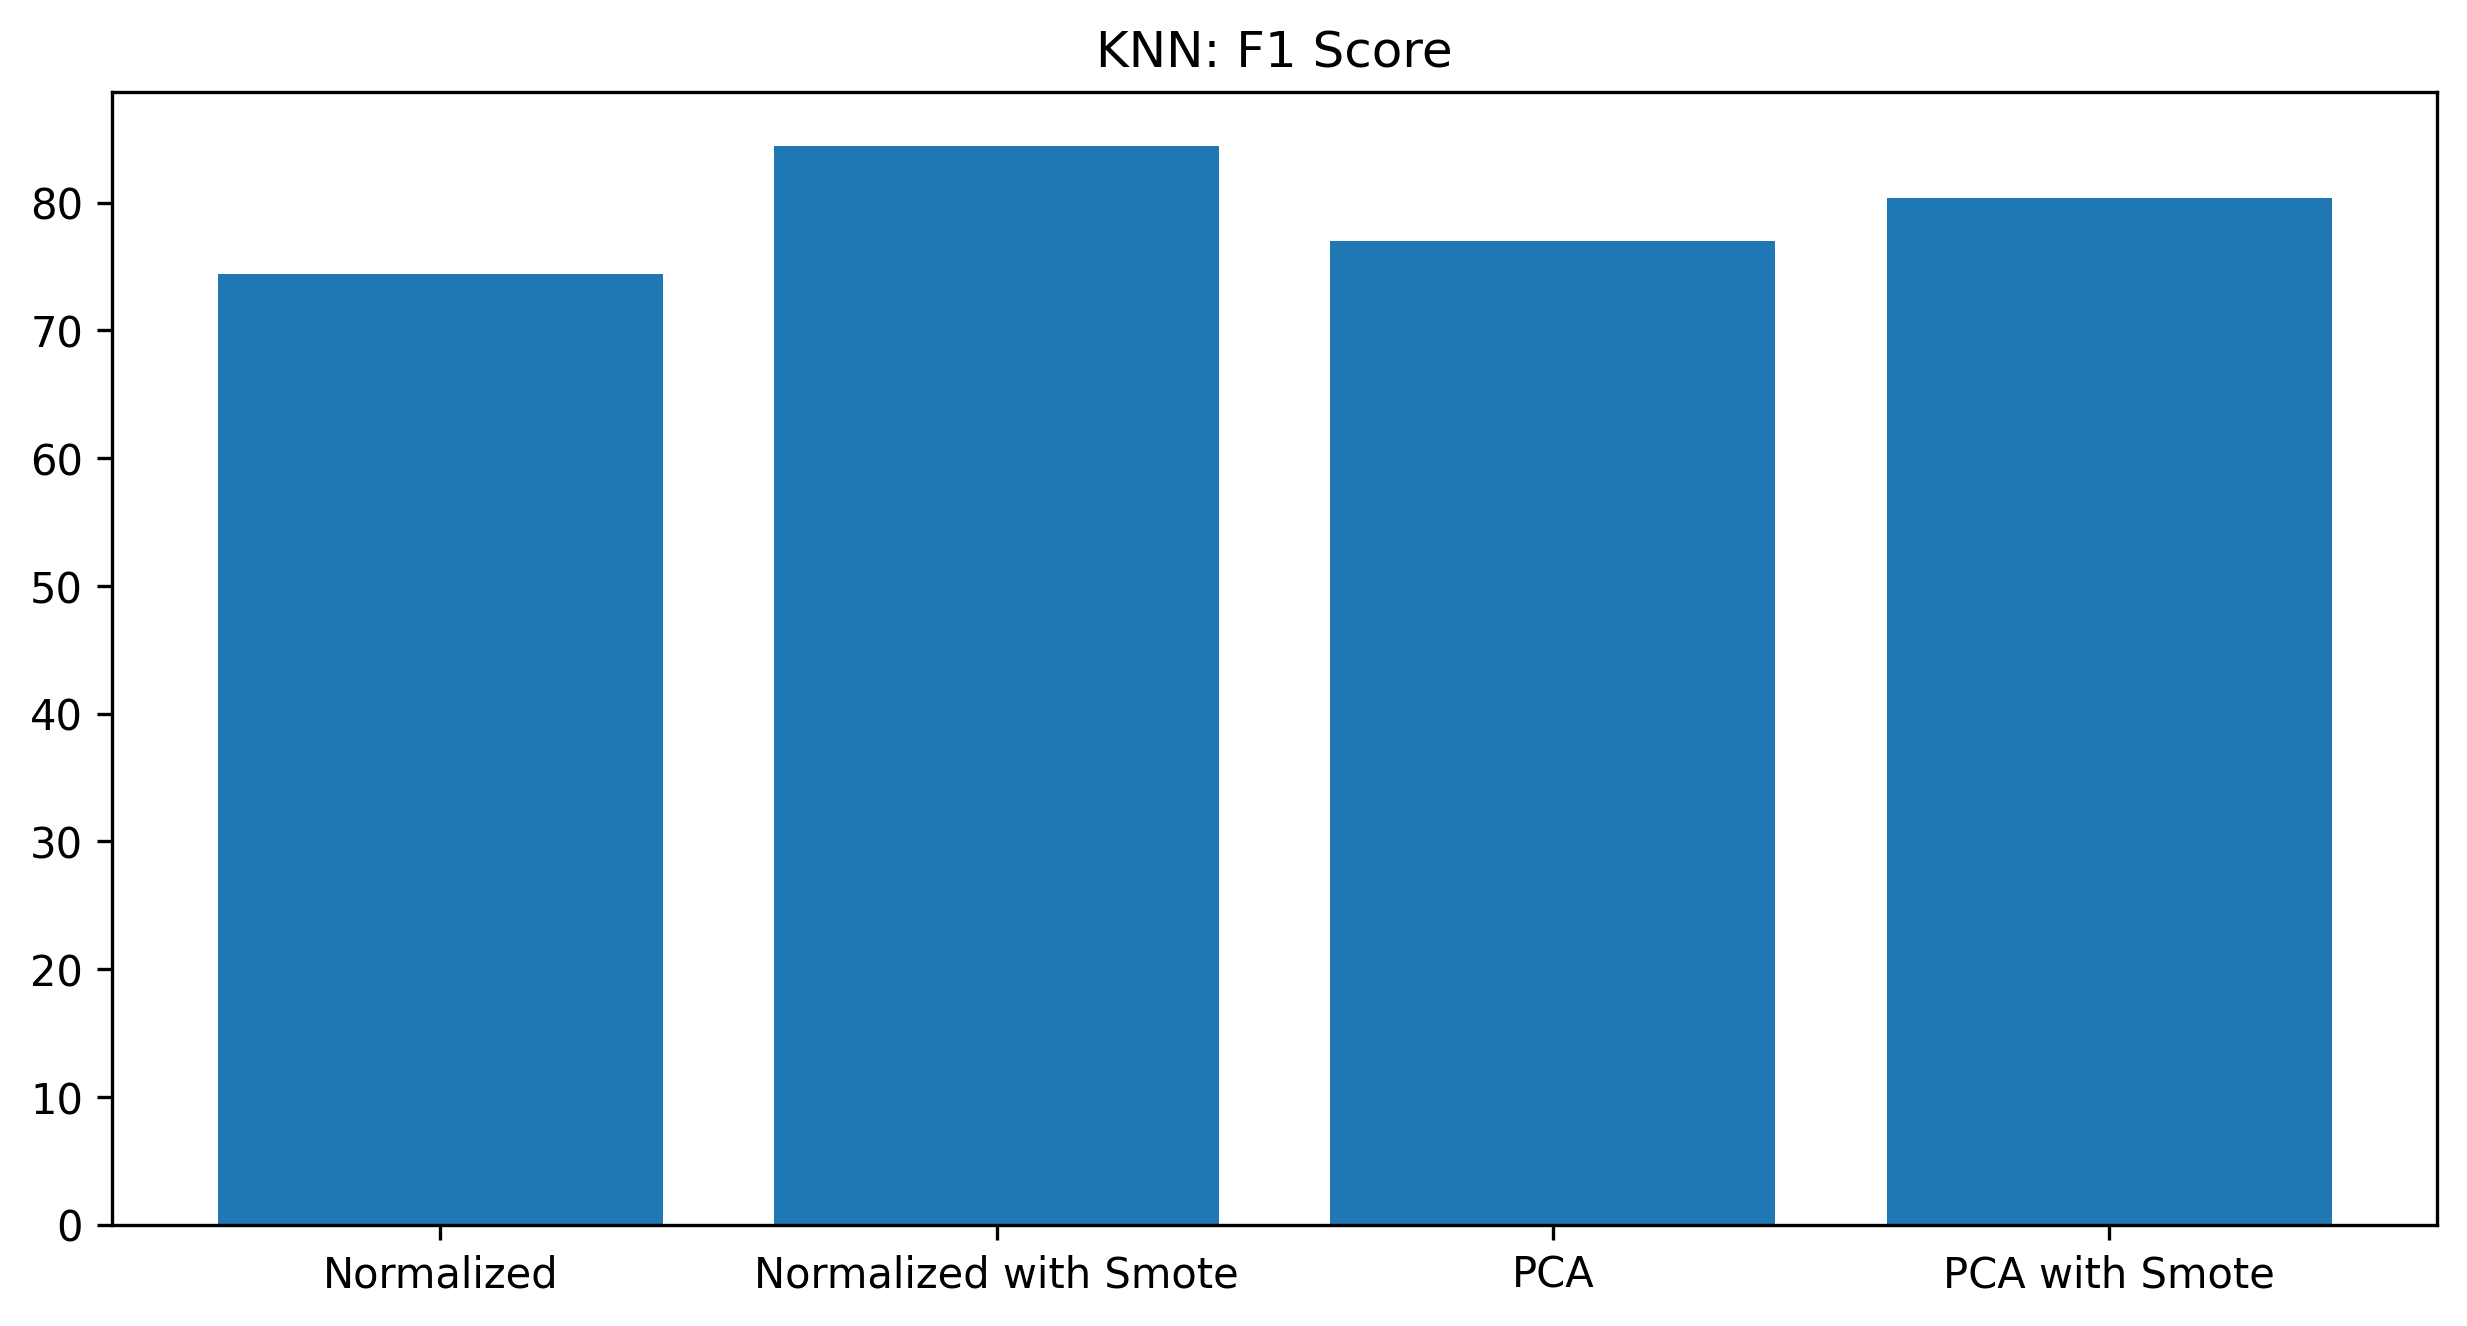

In [21]:
# Plot F1 score

plt.figure(figsize=(10, 5), dpi=300)
plt.bar(
    ['Normalized', 'Normalized with Smote', 'PCA', 'PCA with Smote'], 
    [
        norm_f1 * 100,
        norm_res_f1 * 100,
        pca_f1 * 100,
        pca_res_f1 * 100
    ]
)
plt.title('KNN: F1 Score')

# Save figure
if not os.path.exists('../../figures/KNN'):
    os.makedirs('../../figures/KNN')

plt.savefig('../../figures/KNN/KNN F1 score.png')

plt.show()

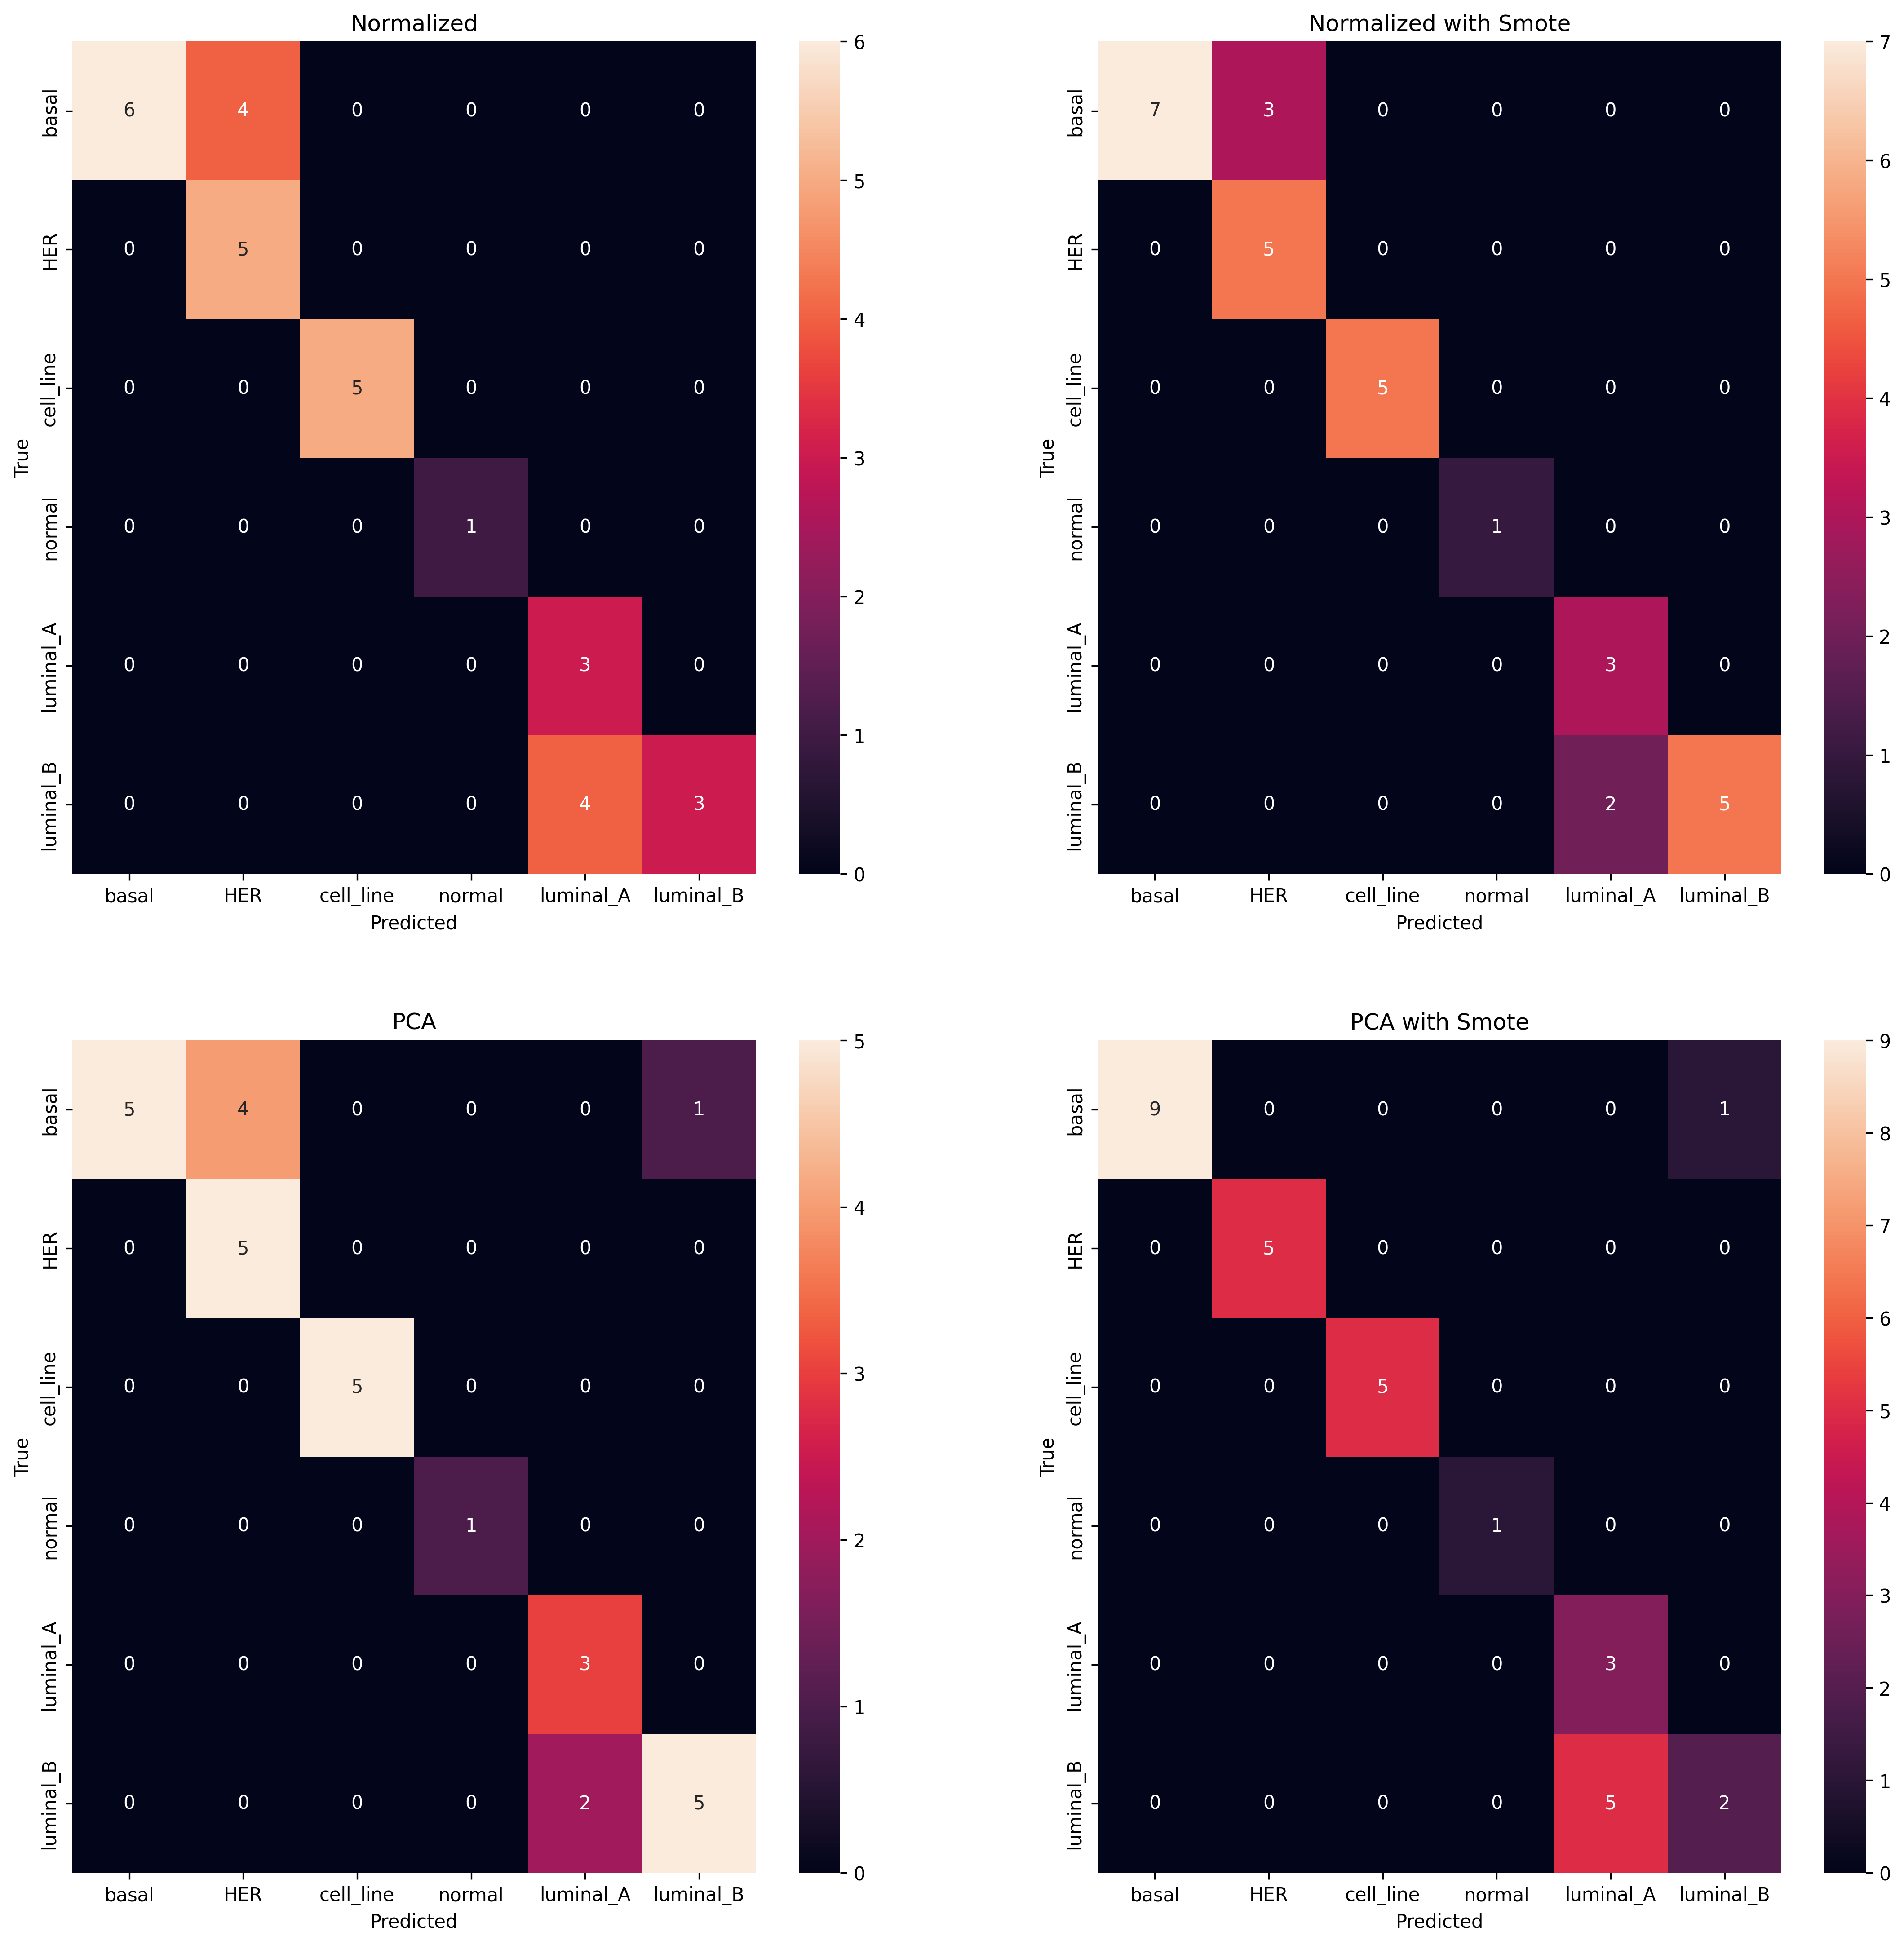

In [22]:
plt.figure(figsize=(18, 18), dpi=300)
plt.subplot(2, 2, 1)
plt.title('Normalized')
sns.heatmap(confusion_matrix(norm_true, norm_pred), annot=True, xticklabels=class_mapping, yticklabels=class_mapping, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')

plt.subplot(2, 2, 2)
plt.title('Normalized with Smote')
sns.heatmap(confusion_matrix(norm_res_true, norm_res_pred), xticklabels=class_mapping, yticklabels=class_mapping, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')

plt.subplot(2, 2, 3)
plt.title('PCA')
sns.heatmap(confusion_matrix(pca_true, pca_pred), annot=True, xticklabels=class_mapping, yticklabels=class_mapping, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')

plt.subplot(2, 2, 4)
plt.title('PCA with Smote')
sns.heatmap(confusion_matrix(pca_res_true, pca_res_pred), xticklabels=class_mapping, yticklabels=class_mapping, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')

# Save figure
if not os.path.exists('../../figures/KNN'):
    os.makedirs('../../figures/KNN')

plt.savefig('../../figures/KNN/KNN Confusion matrix.png')

plt.show()

## Save models

In [23]:
if not os.path.exists(models_path):
    os.makedirs(models_path)

print('Saving models...', models_path)
pickle.dump(norm_model, open(models_path + 'norm_model.pickle', "wb"))
pickle.dump(norm_res_model, open(models_path + 'norm_res_model.pickle', "wb"))

pickle.dump(pca_model, open(models_path + 'pca_model.pickle', "wb"))
pickle.dump(pca_res_model, open(models_path + 'pca_res_model.pickle', "wb"))

print("Done!")

Saving models... saved_models/KNN/
Done!
